100%|██████████| 200/200 [00:00<00:00, 581331.12it/s]

Data saved



Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


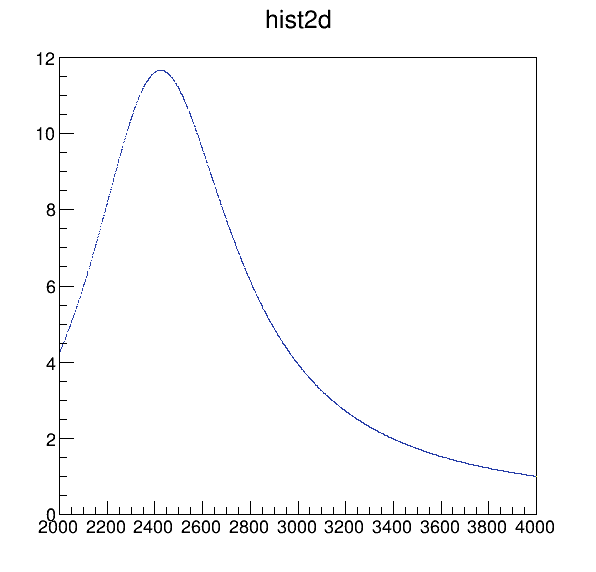

In [16]:
from pathlib import Path
import ROOT
import numpy as np
import pandas as pd
from tqdm import tqdm

ROOT.ROOT.EnableImplicitMT()

signal_type = "signal_sch"
mAp = 50
f = f"downloads/{signal_type}/dp_ana/merge_{mAp}MeV.root"

if not Path(f).exists():
    print(f, "not found")
    exit()
rdf = ROOT.RDataFrame("dp",f)
var_x = "Truth_Positron_E"
var_y = "mcEventWeight"
dx = 1
x_range = [2000, 4000]
dy = 0.01
y_range = [0, 12]
y_binning = (int((y_range[1] - y_range[0]) / dy), y_range[0], y_range[1])
x_binning = (int((x_range[1] - x_range[0]) / dx), x_range[0], x_range[1])

hist2d = rdf.Histo2D(("hist2d", "hist2d", *x_binning, *y_binning), var_x, var_y)
# Create a profile histogram to get the mean values
profile = hist2d.ProfileX()
# Draw the 2D histogram and save it
c1 = ROOT.TCanvas("canvas", "canvas", 600, 600)
hist2d.Draw()
hist2d.SetStats(False)
c1.Draw()

data = {"center": [], "y_val": [], "y_err": []}
for bin in tqdm(range(1, profile.GetNbinsX() + 1, 10)):
    center = profile.GetBinCenter(bin)
    y_val = profile.GetBinContent(bin)
    if y_val != 0:
        data["center"].append(center)
        data["y_val"].append(y_val)
        data["y_err"].append(np.sqrt(dy*dy + dy*dy * y_val*y_val))
    
df = pd.DataFrame(data)
output_path = Path("output/weight_validation")
output_path.mkdir(parents=True, exist_ok=True)
df.to_csv(output_path / f"{signal_type}_{mAp}MeV.csv", index=False)
print("Data saved")

In [2]:
import plotly.graph_objs as go
import pandas as pd
import numpy as np
from tools.plot import plot_style, plot_ratio
import math
import numpy as np
from plotly.offline import plot
from pathlib import Path


def write_fig(fig, filename):
    OUTPUT_DIR = Path("output/weight_validation")
    filepath=f"{OUTPUT_DIR}/plot/<format>/{filename}.<format>"
    for out_format in ['json', 'pdf', 'png']:
        (OUTPUT_DIR / "plot" / out_format).mkdir(parents=True, exist_ok=True)
        fig.write_image(filepath.replace('<format>', out_format), scale=2 if out_format == 'png' else 1)

    # HTML
    plotly_config = {
        'toImageButtonOptions': {
            'format': 'png',  # Change to 'svg' here
            'scale': 2,  # Increase scale in case of high-resolution images
            'filename': 'custom_image',
        }
    }
    (OUTPUT_DIR / "plot/html").mkdir(parents=True, exist_ok=True)
    plotly_config['toImageButtonOptions']['filename'] = filename
    plot(fig, config=plotly_config, filename=filepath.replace('<format>','html'), auto_open=False, include_mathjax = 'cdn')

def get_sigma(mAp, E0, signal_process):
    sigma = 0
    me = 0.511  # MeV
    alphaEM = 1.0 / 137.0  # fine structure constant
    alphaD = 0.5  # dark sector fine structure constant
    epsilon = 1.0  # mixing parameter
    r = 1.0 / 3.0  # mX/mA'
    mX = r * mAp
    # the cross section of e+e- -> A'A is given by Eq.(4) in ref: https://journals.aps.org/prd/pdf/10.1103/PhysRevD.98.015031
    if signal_process == "PositronAnnihilationTch":
        s = 2.0 * me * E0 + 2.0 * me * me
        if mAp * mAp <= s:
            f1 = 8.0 * math.pi * alphaEM * alphaEM * epsilon * epsilon / s
            f2 = ((s - mAp * mAp) / (2.0 * s) + mAp * mAp / (s - mAp * mAp)) * math.log(s / (me * me))
            f3 = (s - mAp * mAp) / (2.0 * s)
            sigma = f1 * (f2 - f3) * 1.973 * 1.973 * 1e14
        else:
            sigma = 0
    # the cross section of e+e- -> A', A'->XX is given by Eq.(3) in ref: https://journals.aps.org/prd/pdf/10.1103/PhysRevD.104.L091701
    if signal_process == "PositronAnnihilationSch":
        s = 2.0 * me * E0 + 2.0 * me * me
        if 4.0 * mX * mX <= s:
            q = 0.5 * math.sqrt(s - 4.0 * mX * mX)
            Kappa = s - 4.0 / 3.0 * q * q
            GamAp = alphaD * mAp * (1.0 + 2.0 * r * r) * math.sqrt(1.0 - 4.0 * r * r) / 3.0
            eta = (s / (mAp * mAp)) * (s / (mAp * mAp))
            f1 = 4.0 * math.pi * alphaEM * alphaD * epsilon * epsilon / math.sqrt(s)
            f2 = (s - mAp * mAp) * (s - mAp * mAp) + GamAp * GamAp * mAp * mAp * eta
            sigma = f1 * q * Kappa / f2 * 1.973 * 1.973 * 1e14
        else:
            sigma = 0
    return sigma

def get_sigma_array(mAp, E0_array, signal_process):
    return np.array([get_sigma(mAp, E0, signal_process) for E0 in E0_array])

# Read the data
signal_type = "signal_sch"
mAp = 50
df = pd.read_csv(f"output/weight_validation/{signal_type}_{mAp}MeV.csv")
process_type = {
    "signal_sch" : "PositronAnnihilationSch",
    "signal_tch" : "PositronAnnihilationTch"
}
proc_labels = {
    "signal_sch": f"e<sup>+</sup> e<sup>-</sup> → A' → X X<br>m<sub>A'</sub> = {mAp} MeV",
    "signal_tch":  f"e<sup>+</sup> e<sup>-</sup> → γ A'<br>m<sub>A'</sub> = {mAp} MeV",
}

x = df["center"]
y1 = df["y_val"]
y2 = get_sigma_array(mAp, x, process_type[signal_type]) / get_sigma(mAp, 4000, process_type[signal_type])
diff = y2/y1
diff[diff == 0] = None
diff_err = df["y_err"]/y1
# Plot the data
fig = plot_ratio(
    x=x,
    y1=y1,
    y2=y2,
    diff=diff,
    annotation_text=proc_labels[signal_type],
    diff_err_band=diff_err.tolist(),
    labels=["Formula","MC"],
    y_label="Weight",
    x_label="E<sub>0</sub>",
)

fig.show()
write_fig(fig, f"{signal_type}_{mAp}MeV")